In [2]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from scipy.signal import convolve2d
import cv2

import os

In [3]:
def get_video_frames(fname):
    video = mpy.VideoFileClip(fname)
    n_frames = video.reader.nframes
    fps = video.fps
    
    frames = []
    for i in range(n_frames):
        frame = video.get_frame(i*1.0/fps)
        frames.append(frame)
        
    return frames, n_frames, fps

In [4]:
def render_video(frames, fname, fps=30):
    clip = mpy.ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(fname, codec='libx264')

In [5]:
def lucas_kanade(image1, image2, points, window_size=5, blur_window_size=None, tau=1e-2, grayscale=False):
    assert type(points) == list, "Param 'points' must be type list"
    assert type(grayscale) == bool, "Param 'grayscale' must be type bool"
    
    if grayscale:
        gray_im1 = image1
        gray_im2 = image2
    else:
        gray_im1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        gray_im2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    if blur_window_size:
        assert type(blur_window_size) == int, "Param 'blur_window_size' must be type int"
        gray_im1 = cv2.GaussianBlur(gray_im1, (blur_window_size, blur_window_size), 0)
        gray_im2 = cv2.GaussianBlur(gray_im2, (blur_window_size, blur_window_size), 0)

    of_directions = []
    points_next = []
    for point in points:
        x_coord, y_coord = point
        w = window_size // 2

        x_filter = np.array([[-1, 1], [-1, 1]], np.float64) * 1/4
        y_filter = np.array([[-1, -1], [1, 1]], np.float64) * 1/4
        t_filter = np.array([[1, 1], [1, 1]], np.float64) * 1/4

        Ix = convolve2d(gray_im1, x_filter, "same") + convolve2d(gray_im2, x_filter, "same")    # Derivative in X direction
        Iy = convolve2d(gray_im1, y_filter, "same") + convolve2d(gray_im2, y_filter, "same")    # Derivative in Y direction
        It = convolve2d(gray_im1, t_filter, "same") + convolve2d(gray_im2, -t_filter, "same")    # Derivative in XY direction

        # Method applied below is explained here in details
        # http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/Lucas-Kanade2.pdf
        Sx = Ix[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()
        Sy = Iy[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()
        St = It[y_coord-w:y_coord+w+1, x_coord-w:x_coord+w+1].flatten()

        S = np.array([[np.sum(np.power(Sx, 2)), np.sum(np.multiply(Sx, Sy))],
                      [np.sum(np.multiply(Sx, Sy)), np.sum(np.power(Sy, 2))]])
        U = np.array([[np.sum(np.multiply(Sx, St))],
                      [np.sum(np.multiply(Sy, St))]])

        # Instead of calculating the eigenvalues matrix by hand, I used pinv for a similar result
        # pinv handles the ill condition for us <3
        of_direction = np.dot(np.linalg.pinv(S), -U)
        
        of_directions.append(np.array([of_direction[0], of_direction[1]]))
        x_next_coord = int(x_coord + np.round(of_direction[0]))
        y_next_coord = int(y_coord + np.round(of_direction[1]))
        points_next.append((x_next_coord, y_next_coord))
    
    of_directions = np.array(of_directions)
    return points_next, of_directions

In [6]:
def draw_arrow(frame, points, of_directions, scale_factor=5, color=(255, 190, 25), thickness=1, tip_length=0.3):
    of_directions = of_directions.reshape((-1, 2))
    points_next = np.round(np.add(points, np.multiply(of_directions, scale_factor)))
    
    start_pos = tuple(np.mean(points, axis=0, dtype=np.int32))
    end_pos = tuple(np.mean(points_next, axis=0, dtype=np.int32))

    # Default value for color is yellow (RGB)
    frame = cv2.arrowedLine(frame, start_pos, end_pos, color, thickness, tipLength=tip_length)
    return frame

In [7]:
def inspect_frame(frame):
    %matplotlib qt
    plt.imshow(frame)

In [36]:
video_fname = "movie_001.avi"
frames, n_frames, fps = get_video_frames(video_fname)
inspect_frame(frames[0])

n_frames = 100
frames = frames[:n_frames]

In [26]:
def mask_ball(frame, color):
    if color == "b":
        lower = (65, 75, 225)
        upper = (85, 95, 255)
    elif color == "r":
        pass
    elif color == "g":
        pass
    elif color == "p":
        pass
    else:
        assert RuntimeError, "Color unrecognized"
        
    mask = cv2.inRange(frame, lower, upper)
    kernel = np.ones((7, 7), dtype=np.uint8)
    erosion = cv2.erode(mask, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    mask = dilation
    f_masked = cv2.bitwise_and(frame, frame, mask=mask)
        
    return mask, f_masked

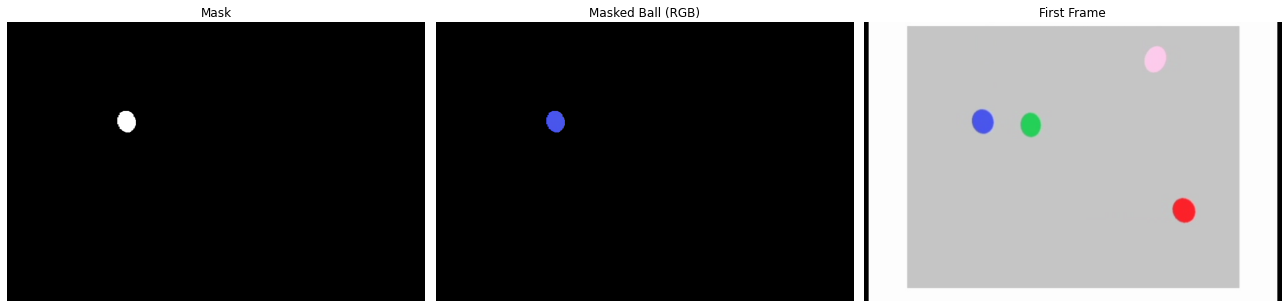

In [44]:
%matplotlib inline
resized_frame = frames[20]
# resized_frame = cv2.resize(resized_frame, (180, 120), interpolation=cv2.INTER_AREA)

mask, f_masked = mask_ball(resized_frame, color="b")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
axes[0].imshow(mask, cmap="gray")
axes[0].set_title("Mask")
axes[1].imshow(f_masked)
axes[1].set_title("Masked Ball (RGB)")
axes[2].imshow(resized_frame)
axes[2].set_title("First Frame")
[axis.axis("off") for axis in axes]
plt.tight_layout()
plt.show()

#### Self-Implemented Lucas Kanade

In [34]:
%matplotlib inline
video_fname = "movie_001.avi"
frames, n_frames, fps = get_video_frames(video_fname)

# for idx, frame in enumerate(frames):
#     frames[idx] = cv2.resize(frame, (180, 120), interpolation=cv2.INTER_AREA)

n_frames = 100
frames = frames[:n_frames]

blue_p = [(194, 167), (217, 169), (194, 183), (217, 187)]    # LT, RT, LB, RB
# blue_p = [(49, 40), (53, 40), (49, 46), (53, 46)]

i = 0
while i < n_frames - 2:
    f = frames[i]
    f_next = frames[i+1]
    f_next2 = frames[i+2]
    
    f_mask, _ = mask_ball(f, "b")
    f_next2_mask, _ = mask_ball(f_next2, "b")
    
    next_blue_p, of_directions = lucas_kanade(f_mask, f_next2_mask, blue_p, window_size=3, blur_window_size=None, grayscale=True)
    
    frames[i] = draw_arrow(f, blue_p, of_directions, scale_factor=8, thickness=2, tip_length=0.2)
    blue_p = next_blue_p
    i += 1
    
render_video(frames, "movie_001_output.avi", fps=4)

t:  40%|████      | 40/100 [00:00<00:00, 395.90it/s, now=None]

Moviepy - Building video movie_001_output.avi.
Moviepy - Writing video movie_001_output.avi



Moviepy - Done !
Moviepy - video ready movie_001_output.avi


#### OpenCV OF Method